# Example 1: running GLMsingle on an example session from the Natural Scenes Dataset; comparing voxel reliability across versions

In [1]:
import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
import scipy.io as sio
import matplotlib.pyplot as plt
import nibabel as nib

import os
from os.path import join, exists, split
import sys
import time
import urllib.request
import copy
import warnings
from tqdm import tqdm
from pprint import pprint
warnings.filterwarnings('ignore')

import glmsingle
from glmsingle.glmsingle import GLM_single

# Step 1: load fMRI dataset

In [2]:
homedir = split(os.getcwd())[0]

datadir = join(homedir,'examples','data')
os.makedirs(datadir,exist_ok=True)

datafn = join(datadir,'nsdcoreexampledataset.mat')

print(f'directory to save example dataset:\n{datadir}')

directory to save example dataset:
/Volumes/T7/research/projects/GLMsingle/examples/data


In [3]:
# download example dataset from GLMsingle OSF repository:
# NSD subj01, session NSD01, one slice of functional data -> 750 experimental stimuli over 12 runs
if not exists(datafn):
    
    print(f'Downloading example dataset and saving to:\n{datafn}')
    
    dataurl = 'https://osf.io/k89b2/download'
    
    # download the .mat file to the specified director
    urllib.request.urlretrieve(dataurl, datafn)
    
# load struct containing example dataset
X = sio.loadmat(datafn)

# get metadata about stimulus duration and TR
stimdur = X['stimdur'][0][0]
tr = X['tr'][0][0]

In [4]:
data = []
design = []

# iterate through each run of data
for r in range(len(X['data'][0])):
    
    # index into struct, append each run's timeseries data to list
    data.append(X['data'][0,r])
    
    # convert each run design matrix from sparse array to full numpy array, append
    design.append(scipy.sparse.csr_matrix.toarray(X['design'][0,r]))
    
print(data[0].shape)
xyz = data[0].shape[:3]

(145, 186, 1, 300)


data -> consists of several runs of 4D volume files (x,y,z,t) where (t)ime is the 4th dimention. In this example data consists of only a single slice and has been prepared with a TR = 1s

ROI -> manually defined region in the occipital cortex. It is a binary matrix where (x,y,z) = 1 corresponds to the cortical area that responded to visual stimuli used in the NSD project.

# visualize data and design matrix

In [5]:
print(f'data has {len(data)} runs')
print(f'shape of data from each run is: {data[0].shape}')
print(f'XYZ dimensionality is: {data[0].shape[:3]} (one slice only)')
print(f'n = {data[0].shape[3]} TRs per run')
print(f'type of data is: {type(data[0][0,0,0,0])}')

data has 12 runs
shape of data from each run is: (145, 186, 1, 300)
XYZ dimensionality is: (145, 186, 1) (one slice only)
n = 300 TRs per run
type of data is: <class 'numpy.float32'>


Text(0, 0.5, 'time (TR)')

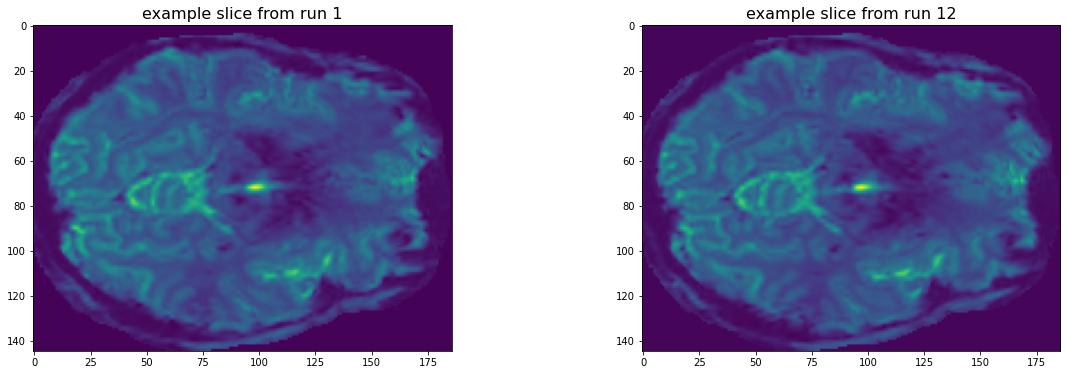

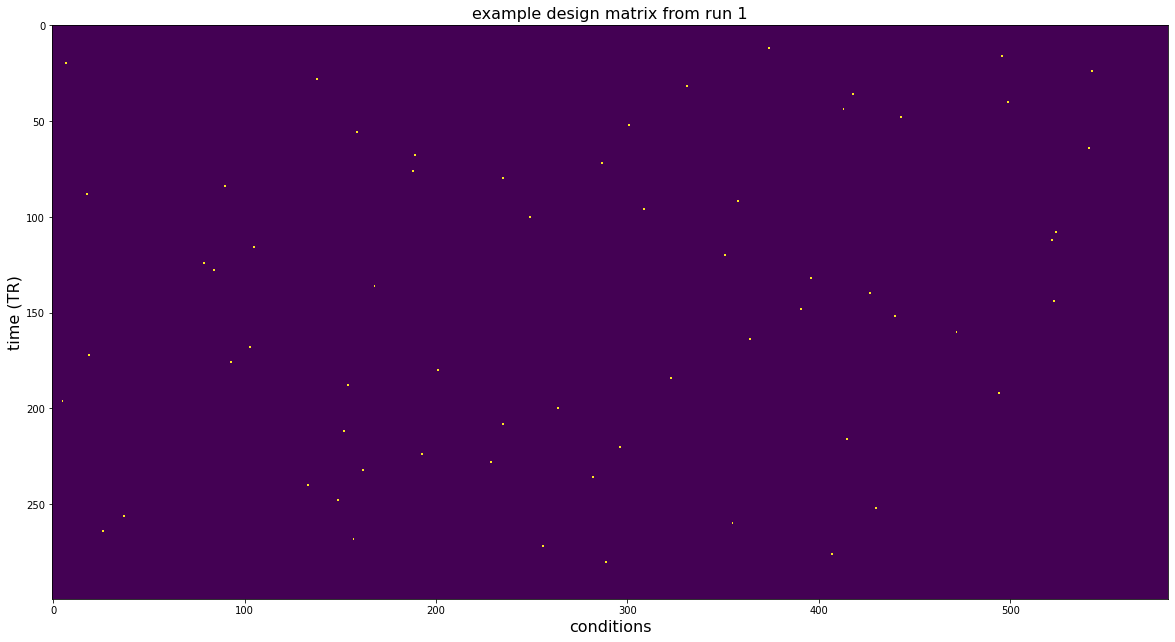

In [6]:
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.imshow(data[0][:,:,0,0])
plt.title('example slice from run 1',fontsize=16)
plt.subplot(122)
plt.imshow(data[11][:,:,0,0])
plt.title('example slice from run 12',fontsize=16)

plt.figure(figsize=(20,20))
plt.imshow(design[0],interpolation='none')
plt.title('example design matrix from run 1',fontsize=16)
plt.xlabel('conditions',fontsize=16)
plt.ylabel('time (TR)',fontsize=16)

design -> Each run has a corresponding design matrix where each column
describes a single condition (conditions are repeated across runs). 
Each design matrix is binary with 1 specfing the time (TR) when the stimulus 
is presented on the screen.

In this NSD scan session there were 583 distinct images shown and hence
there are 583 predictor columns/conditions. Notice that white rectangles 
are pseudo randomized and they indicate when the presentaion of each 
image occurs. Note that in some runs not all images are shown, if a
column does not have a white rectangle it means that this image is
shown in a different run.

# Step 2: Run baseline GLM (canonical HRF and no optimizations) using GLMsingle

In [7]:
outputdir_baseline = join(homedir,'examples','example1outputs','GLMbaseline')

opt = dict()

# turn off optimizations
opt['wantlibrary'] = 0
opt['wantglmdenoise'] = 0
opt['wantfracridge'] = 0
opt['wantfileoutputs'] = [1,1,0,0]

# For the purpose of this example we will keep the relevant outputs in memory
opt['wantmemoryoutputs'] = [1,1,0,0]

start_time = time.time()

# create GLM_single object
gst_assumehrf = GLM_single(opt)

pprint(gst_assumehrf.params)

{'R2thresh': 0,
 'brainR2': [],
 'brainexclude': False,
 'brainthresh': [99.0, 0.1],
 'chunklen': 50000,
 'extra_regressors': False,
 'fracs': array([1.  , 0.95, 0.9 , 0.85, 0.8 , 0.75, 0.7 , 0.65, 0.6 , 0.55, 0.5 ,
       0.45, 0.4 , 0.35, 0.3 , 0.25, 0.2 , 0.15, 0.1 , 0.05]),
 'hrffitmask': 1,
 'hrfmodel': 'optimise',
 'hrfthresh': 0.5,
 'lambda': 0,
 'n_boots': 100,
 'n_jobs': 1,
 'n_pcs': 10,
 'numforhrf': 50,
 'pcR2cutoff': [],
 'pcR2cutoffmask': 1,
 'pcstop': 1.05,
 'seed': 1627007618.2962701,
 'suppressoutput': 0,
 'wantautoscale': 1,
 'wantfileoutputs': [1, 1, 0, 0],
 'wantfracridge': 0,
 'wantglmdenoise': 0,
 'wantlibrary': 0,
 'wantlss': 0,
 'wantmemoryoutputs': [1, 1, 0, 0],
 'wantparametric': 0,
 'wantpercentbold': 1}


- Outputs and figures will be stored in a folder (you can specify it's name 
as the 5th output to GLMestimatesingletrial.) Model estimates can be also
saved to the results variable which is the only output of 
GLMestimatesingletrial

- Optional parameters below can be assigned to a strucutre i.e
opt = struct('wantlibrary',1,'wantglmdenoise',1); Options are the 6th  
input to GLMestimatesingletrial.

- DEFAULT OPTIONS:

    - wantlibrary = 1 -> Fit HRF to each voxel
    - wantglmdenoise = 1 -> Use GLMdenoise
    - wantfracridge = 1  -> Use ridge regression to improve beta estimates
    - chunknum = 50000 -> is the number of voxels that we will process at the same time. For setups with lower memory deacrease this number.
    - wantmemoryoutputs is a logical vector [A B C D] indicating which of the four model types to return in the output <results>. The user must be careful with this, as large datasets can require a lot of RAM. If you
do not request the various model types, they will be cleared from 
memory (but still potentially saved to disk). Default: [0 0 0 1] which means return only the final type-D model.

    - wantfileoutputs is a logical vector [A B C D] indicating which of the four model types to save to disk (assuming that they are computed).
        - A = 0/1 for saving the results of the ONOFF model
        - B = 0/1 for saving the results of the FITHRF model
        - C = 0/1 for saving the results of the FITHRF_GLMdenoise model
        - D = 0/1 for saving the results of the FITHRF_GLMdenoise_RR model
        - Default: [1 1 1 1] which means save all computed results to disk.

    - numpcstotry (optional) is a non-negative integer indicating the maximum
number of PCs to enter into the model. Default: 10.

    - fracs (optional) is a vector of fractions that are greater than 0
and less than or equal to 1. We automatically sort in descending 
order and ensure the fractions are unique. These fractions indicate 
the regularization levels to evaluate using fractional ridge 
regression (fracridge) and cross-validation. Default: 
fliplr(.05:.05:1). A special case is when <fracs> is specified as a 
single scalar value. In this case, cross-validation is NOT performed 
for the type-D model, and we instead blindly use the supplied 
fractional value for the type-D model.

In [8]:
if not exists(outputdir_baseline):

    # run GLMsingle, fitting the baseline GLM
    results_assumehrf = gst_assumehrf.fit(
       design,
       data,
       stimdur,
       tr,
       outputdir=outputdir_baseline)

    elapsed_time = time.time() - start_time
    print(
        'elapsed time: ',
        f'{time.strftime("%H:%M:%S", time.gmtime(elapsed_time))}'
    )
else:
    results_assumehrf = dict()
    results_assumehrf['typea'] = np.load(join(outputdir_baseline,'TYPEA_ONOFF.npy'),allow_pickle=True).item()
    results_assumehrf['typeb'] = np.load(join(outputdir_baseline,'TYPEB_FITHRF.npy'),allow_pickle=True).item()
    
    xyzn = (xyz[0],xyz[1],xyz[2],results_assumehrf['typeb']['betasmd'].shape[3])
    print(xyzn)

(145, 186, 1, 750)


# Step 3: Visualize baseline GLM outputs

In [9]:
meanvol = results_assumehrf['typea']['meanvol'].reshape(xyz)

onoffR2 = results_assumehrf['typea']['onoffR2'].reshape(xyz)

meanbetas = np.mean(results_assumehrf['typeb']['betasmd'].reshape(xyzn),axis=3)

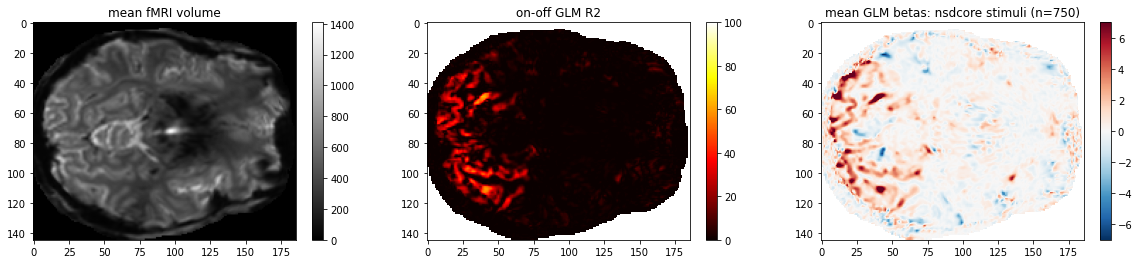

In [10]:
plt.figure(figsize=(20,4))
plt.subplot(131)
plt.imshow(meanvol,aspect='auto',cmap='gray')
plt.colorbar()
plt.title('mean fMRI volume')
plt.subplot(132)
plt.imshow(onoffR2,aspect='auto',clim=(0,100),cmap='hot')
plt.colorbar()
plt.title('on-off GLM R2')
plt.subplot(133)
plt.imshow(meanbetas,aspect='auto',clim=(-7,7),cmap='RdBu_r')
plt.colorbar()
plt.title('mean GLM betas: nsdcore stimuli (n=750)');

In [11]:
# results_assumehrf['typeb'].keys()
# a = results_assumehrf['typeb']['betasmd']
# maxR2 = np.nanmax(R2)
# ix = np.argwhere(R2==maxR2)[0]
# print(ix,a.shape,voxix)
# b = a[ix[0],ix[1], ix[2]]

# plt.bar(np.arange(750),b[:750])

# Step 4: Run GLMsingle with optimizations (library of HRFs, GLMdenoise, fractional ridge regression)

In [12]:
data = []
design = []

for r in range(len(X['data'][0])):
    data.append(X['data'][0,r])
    design.append(scipy.sparse.csr_matrix.toarray(X['design'][0,r]))
    
print(data[0].shape)

(145, 186, 1, 300)


In [13]:
outputdir_glmsingle = join(homedir,'examples','example1outputs','GLMsingle')

opt = dict()
opt['wantlibrary'] = 1
opt['wantglmdenoise'] = 1
opt['wantfracridge'] = 1
opt['wantfileoutputs'] = [1,1,1,1]
opt['wantmemoryoutputs'] = [1,1,1,1]

start_time = time.time()
gst_glmsingle = GLM_single(opt)

pprint(gst_glmsingle.params)

{'R2thresh': 0,
 'brainR2': [],
 'brainexclude': False,
 'brainthresh': [99.0, 0.1],
 'chunklen': 50000,
 'extra_regressors': False,
 'fracs': array([1.  , 0.95, 0.9 , 0.85, 0.8 , 0.75, 0.7 , 0.65, 0.6 , 0.55, 0.5 ,
       0.45, 0.4 , 0.35, 0.3 , 0.25, 0.2 , 0.15, 0.1 , 0.05]),
 'hrffitmask': 1,
 'hrfmodel': 'optimise',
 'hrfthresh': 0.5,
 'lambda': 0,
 'n_boots': 100,
 'n_jobs': 1,
 'n_pcs': 10,
 'numforhrf': 50,
 'pcR2cutoff': [],
 'pcR2cutoffmask': 1,
 'pcstop': 1.05,
 'seed': 1627007618.2962701,
 'suppressoutput': 0,
 'wantautoscale': 1,
 'wantfileoutputs': [1, 1, 1, 1],
 'wantfracridge': 1,
 'wantglmdenoise': 1,
 'wantlibrary': 1,
 'wantlss': 0,
 'wantmemoryoutputs': [1, 1, 1, 1],
 'wantparametric': 0,
 'wantpercentbold': 1}


In [34]:
if not exists(outputdir_glmsingle):

    # run GLMsingle
    results_glmsingle = gst_glmsingle.fit(
       design,
       data,
       stimdur,
       tr,
       outputdir=outputdir_glmsingle)

    elapsed_time = time.time() - start_time
    print(
        'elapsed time: ',
        f'{time.strftime("%H:%M:%S", time.gmtime(elapsed_time))}'
    )
    
else:
    results_glmsingle = dict()
    results_glmsingle['typea'] = np.load(join(outputdir_glmsingle,'TYPEA_ONOFF.npy'),allow_pickle=True).item()
    results_glmsingle['typeb'] = np.load(join(outputdir_glmsingle,'TYPEB_FITHRF.npy'),allow_pickle=True).item()
    results_glmsingle['typec'] = np.load(join(outputdir_glmsingle,'TYPEC_FITHRF_GLMDENOISE.npy'),allow_pickle=True).item()
    results_glmsingle['typed'] = np.load(join(outputdir_glmsingle,'TYPED_FITHRF_GLMDENOISE_RR.npy'),allow_pickle=True).item()


# Step 5: visualize GLMsingle outputs

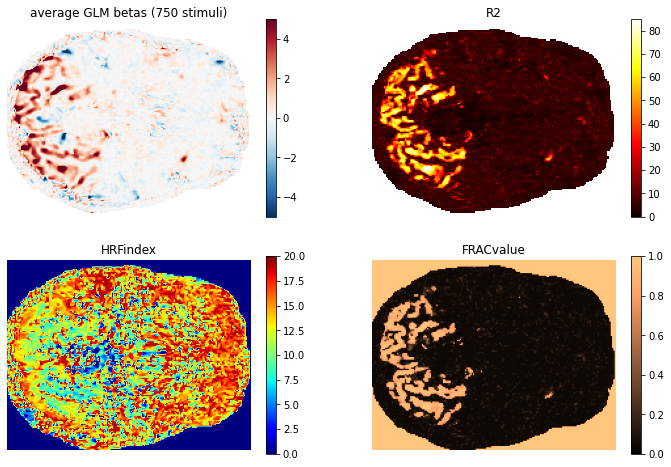

In [55]:
plot_fields = ['betasmd','R2','HRFindex','FRACvalue']
colormaps = ['RdBu_r','hot','jet','copper']
clims = [[-5,5],[0,85],[0,20],[0,1]]

plt.figure(figsize=(12,8))

for i in range(len(plot_fields)):
    plt.subplot(2,2,i+1)
    if i == 0:
        plot_data = np.nanmean(np.squeeze(results_glmsingle['typed'][plot_fields[i]].reshape(xyzn)),2)
        titlestr = 'average GLM betas (750 stimuli)'
    else:
        plot_data = np.squeeze(results_glmsingle['typed'][plot_fields[i]].reshape(xyz))
        titlestr = plot_fields[i]
    
    plt.imshow(plot_data,cmap=colormaps[i],clim=clims[i])
    plt.colorbar()
    plt.title(titlestr)
    plt.axis(False)

# Step 5: gather different beta versions, compare split-half reliability

In [15]:
models = dict()
models['assumehrf'] = results_assumehrf['typeb']['betasmd']
models['fithrf'] = results_glmsingle['typeb']['betasmd']
models['fithrf_glmdenoise'] = results_glmsingle['typec']['betasmd']
models['fithrf_glmdenoise_rr'] = results_glmsingle['typed']['betasmd']

In [16]:
# consolidate design matrices
designALL = np.concatenate(design,axis=0)

# compute a vector containing 0-indexed condition numbers in chronological order
corder = []
for p in range(designALL.shape[0]):
    if np.any(designALL[p]):
        corder.append(np.argwhere(designALL[p])[0,0])
        
corder = np.array(corder)
corder[:3]

array([374, 496,   7])

In [17]:
repindices = []

for p in range(designALL.shape[1]):
    temp = np.argwhere(corder==p)[:,0]
    if len(temp) >= 2:
        repindices.append([temp[0], temp[1]])

repindices = np.vstack(np.array(repindices)).T      
print(repindices[:,:3])

print(f'there are {repindices.shape[1]} repeated conditions in the experiment')

[[216 217  18]
 [485 620 123]]
there are 136 repeated conditions in the experiment


(-0.5, 185.5, 144.5, -0.5)

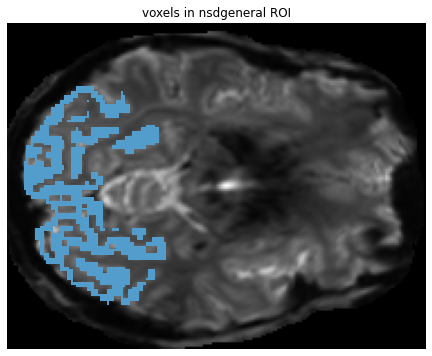

In [18]:
# get mask defining liberal visual cortex ROI
nsdgeneral_roi = X['ROI'].reshape(xyz).astype(float)
nsdgeneral_roi[nsdgeneral_roi==0] = np.nan

plt.figure(figsize=(12,6))
plt.imshow(meanvol,cmap='gray')
plt.imshow(nsdgeneral_roi,cmap='Blues',clim=(0,1.75))

plt.title('voxels in nsdgeneral ROI')
plt.box(False)
plt.axis(False)

In [19]:
vox_reliabilities = []
modelnames = list(models.keys())

for m in range(len(modelnames)):
    print(modelnames[m])
    time.sleep(1)
    betas = models[modelnames[m]][:,:,:,repindices]
    x,y,z = betas.shape[:3] 
    
    rels = np.full((x,y,z),np.nan)
    
    for xx in tqdm(range(x)):
        for yy in range(y):
            for zz in range(z):
                rels[xx,yy,zz] = np.corrcoef(betas[xx,yy,zz,0],
                                             betas[xx,yy,zz,1])[1,0]
          
    vox_reliabilities.append(rels)


assumehrf


100%|██████████| 145/145 [00:17<00:00,  8.41it/s]


fithrf


100%|██████████| 145/145 [00:18<00:00,  7.81it/s]


fithrf_glmdenoise


100%|██████████| 145/145 [00:16<00:00,  8.85it/s]


fithrf_glmdenoise_rr


100%|██████████| 145/145 [00:22<00:00,  6.42it/s]


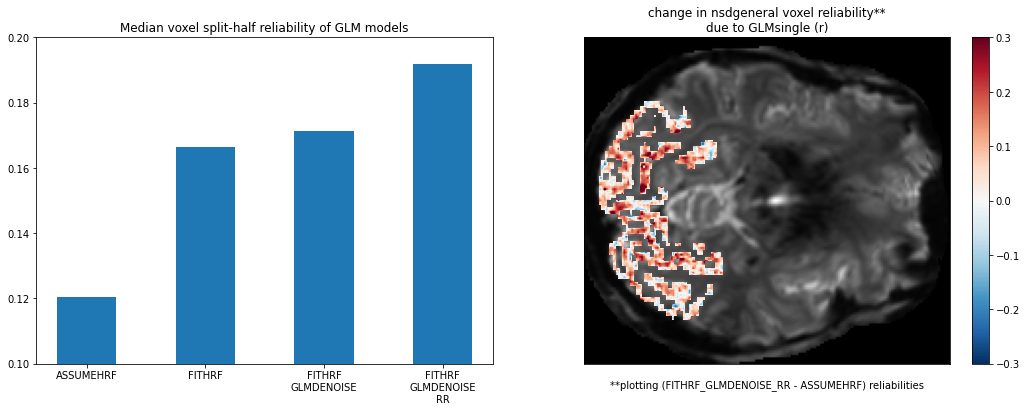

In [56]:
comparison = []
for vr in vox_reliabilities:
    comparison.append(np.nanmedian(vr[nsdgeneral_roi==1]))

plt.figure(figsize=(18,6))
plt.subplot(121)
plt.bar(np.arange(len(comparison)),comparison,width=0.5)
plt.title('Median voxel split-half reliability of GLM models')
plt.xticks(np.arange(4),np.array(['ASSUMEHRF', 'FITHRF', 'FITHRF\nGLMDENOISE', 'FITHRF\nGLMDENOISE\nRR']));
plt.ylim([0.1,0.2])

vox_improvement = vox_reliabilities[3] - vox_reliabilities[0]
vox_improvement[nsdgeneral_roi != 1] = np.nan

plt.subplot(122)
plt.imshow(meanvol,cmap='gray',aspect='auto')
plt.imshow(vox_improvement,cmap='RdBu_r',clim=(-0.3,0.3),aspect='auto')
plt.colorbar()
plt.title('change in nsdgeneral voxel reliability**\ndue to GLMsingle (r)')
plt.xticks([])
plt.yticks([])
plt.xlabel('\n**plotting (FITHRF_GLMDENOISE_RR - ASSUMEHRF) reliabilities');
